# Machine Learning on 5HT2A Receptor

Goal of this notebook is to use the features extracted and analyzed on the other Analysis notebook.  
We want to differentiate agonist ligands from antagonists using features extracted from the MD simulations.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from AnalysisActor.AnalysisActorClass import AnalysisActor
from AnalysisActor.utils import create_analysis_actor_dict

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import re
import os
import subprocess
import logging
import math
import itertools
from operator import itemgetter

from tqdm.notebook import tqdm
from IPython.display import display

## Reading the Simulations

We will use the `AnalysisActor` package I wrote which is able to extract on low level features from the simulations. I call it low level since for example the `AnalysisActor.class` of a ligand will give us the $Rg$ of the ligand on each frame. This must be then reduced to features that I have analyzed like mean and std for each ligand.

In [2]:
# Reading the simulations
analysis_actors_dict = create_analysis_actor_dict('../datasets/New_AI_MD/')

Agonists | Lorcaserin:   7%|▋         | 1/15 [00:02<00:31,  2.24s/it]/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:259: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.rad2deg(np.arccos(np.dot(y, z) / (ly * lz)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:260: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.rad2deg(np.arccos(np.dot(x, z) / (lx * lz)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:261: RuntimeWarning: invalid value encountered in double_scalars
  gamma = np.rad2deg(np.arccos(np.dot(x, y) / (lx * ly)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:264: RuntimeWarning: invalid value encountered in greater
  if np.all(box > 0.0) and alpha < 180.0 and beta < 180.0 and gamma < 180.0:
Agonists | Donitriptan: 100%|██████████| 15/15 [00:36<00:00,  2.

The `analysis_actors_dict` is a dictionary:
```python 
{
    "Agonists": List[AnalysisActor.class]
    "Antagonists": List[AnalysisActor.class]
}
```
This dictionary currently has only read the trajectories and has not calculated any of its metrics.  In order to do that we must call the `AnalysisActor.perform_analysis` method, which takes as an argument a list of metrics to be calculated.  
  
**Care**: The calculations need memory in order to be calculated and stored, so monitor the memory usage. If this becomes too big of a problem we can solve it in a "dynamic" way meaning that we will not keep saved the trajectories but demand them briefly for the calculations to be executed. 

In [3]:
# Possible arguments for "metrics" list:
#     Empty List [] (default): All of the available metrics will be calculated
#     'Rg': Radius of Gyration
#     'RMSF': Root Mean Square Fluctuations
#     'SASA': Solvent Accessible Surface Area
#     'PCA': Principal Component Analysis
#     'Hbonds': Hydrogen Bonds
#     'Salt': Calculate number of salt bridges

# Iterate on all the ligands
for which_ligand in tqdm(analysis_actors_dict['Agonists'] + analysis_actors_dict['Antagonists'], desc="Ligand Calculations"):
    which_ligand.perform_analysis(metrics=["Rg", "SASA"])

## Extracting the Features

From the calculations we must now extract ML appropriate features. The features used in our case are:
* Mean of Rg
* Std of Rg
* Mean of SASA
* Std of SASA

One parameter one must think of is the window of the features. Our simulations are of 2.500 and using all of them may  not be ideal. Our analysis actually shows that the event happens after 1.200 frames in most cases. However, as a starting point we will use all of the frames.  
  
**As labels we will use:**
* Agonist: 1
* Antagonist: 0

In [4]:
def create_dataset(analysis_actors_dict, start=0, stop=2500):
    """
    Creates the df containing the feature columns and as the last column the labels.
    Currently the features are Rg mean, Rg std, SASA mean, SASA std.
    
    Args:
        analysis_actors_dict:   {
                                    "Agonists": List[AnalysisActor.class]
                                    "Antagonists": List[AnalysisActor.class]
                                }
                                
        start(int): The starting frame of the simulation we are using for the features
        stop(int): The starting last of the simulation we are using for the features
        
    Returns:
        pd.DataFrame of #ligands rows and #features + 1 (for the labels) columns 
        
    """
    full_dataset = []
    
    # Iterate on the agonists
    for which_ligand in analysis_actors_dict['Agonists']:
        # Rg
        mean_rg = np.mean(which_ligand.get_radius_of_gyration()[start:stop])
        std_rg = np.std(which_ligand.get_radius_of_gyration()[start:stop])

        # SASA
        mean_sasa = np.mean(which_ligand.get_sasa()[1][start:stop])
        std_sasa = np.std(which_ligand.get_sasa()[1][start:stop])

        # For each ligand we will create a vector of [Mean Rg, Std Rg, Mean SASA, Std SASA, Ligand_Label]
        full_dataset.append([mean_rg, std_rg, mean_sasa, std_sasa, 1])

    # Iterate on the antagonists
    for which_ligand in analysis_actors_dict['Antagonists']:
        # Rg
        mean_rg = np.mean(which_ligand.get_radius_of_gyration()[start:stop])
        std_rg = np.std(which_ligand.get_radius_of_gyration()[start:stop])

        # SASA
        mean_sasa = np.mean(which_ligand.get_sasa()[1][start:stop])
        std_sasa = np.std(which_ligand.get_sasa()[1][start:stop])

        # For each ligand we will create a vector of [Mean Rg, Std Rg, Mean SASA, Std SASA, Ligand_Label]
        full_dataset.append([mean_rg, std_rg, mean_sasa, std_sasa, 0])

    dataset_df = pd.DataFrame(full_dataset, columns=['RgMean', 'RgStd', 'SASAMean', 'SASAstd', 'LigandLabel'])
    
    return dataset_df

## Evaluating


The main problem in our task is the little number of data points. This means that a good (or bad) result may be random and not reflect the reality.  
Having the hyperparameters chosen (either by us or the tuning part of my pipeline) we must evaluate and analyze the final model.

In [77]:
def evaluate_params(estimator, X, y, folds=5, verbose=True):
    """
    Given an object estimator calculate Acc, f1, rec, auc using k-fold cross validation. This can be further
    expanded to create confusion matrices.
    
    Args:
        estimator (estimator Object): Object implementing the scikit-learn estimator interface
        X (np.array): Matrix of the features of the input dataset
        y (np.array): Vector of the labels of the ligands
        folds (int): Number of fold of the CV
        verbose (boolean): Currently chooses if we will print the per fold metrics or the total average metrics only
    """
    
    # This dict will be used to save the metrics of each fold
    total_metrics_train = {
        "acc": 0,
        "f1": 0,
        "rec": 0,
        "auc": 0
    }

    total_metrics_test = {
        "acc": 0,
        "f1": 0,
        "rec": 0,
        "auc": 0
    }

    def calculate_metrics(y_true, y_pred, total_metrics, y_pred_probs=None, print_enabled=True):
        # Calculate metrics
        acc = metrics.accuracy_score(y_true, y_pred)
        f1 = metrics.f1_score(y_true, y_pred)
        rec = metrics.recall_score(y_true, y_pred)
        if y_pred_probs is not None:
            auc = metrics.roc_auc_score(y_true, y_pred_probs)

        # Update total metrics
        total_metrics['acc'] += acc
        total_metrics['f1'] += f1
        total_metrics['rec'] += rec
        if y_pred_probs is not None:
            total_metrics['auc'] += auc

        # Print metrics
        if print_enabled:
            print(f'\t\tAccuraccy: {acc}')
            print(f'\t\tRecall: {rec}')
            print(f'\t\tF1_Score: {f1}')
            if y_pred_probs is not None:
                print(f'\t\tAUC: {auc}')

    def print_total_metrics(total_metrics, splits):
        print(f'\tAccuraccy: {total_metrics["acc"] / splits}')
        print(f'\tRecall: {total_metrics["rec"] / splits}')
        print(f'\tF1_Score: {total_metrics["f1"] / splits}')
        if total_metrics['auc'] != 0:
            print(f'\tAUC: {total_metrics["auc"] / splits}')

    which_split = 0
    coefs = []
    
    kf = StratifiedKFold(n_splits=folds, shuffle=True)
    for train_index, test_index in kf.split(X, y):
        if verbose:
            print(f'> Split: {which_split}')
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index].astype(int), y[test_index].astype(int)
        
        # Standarization
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)    # Fit and transform the training data
        X_test = scaler.transform(X_test)    # Transform the test data
        
        # We will start with simple models like Logistic Regression
        clf = estimator
    
        clf.fit(X_train, y_train)
    
        # Save the coefs
        coefs.append(clf.coef_[0])
        
        # Predict on training set
        train_pred = clf.predict(X_train)
        train_pred_proba = clf.predict_proba(X_train)[:, 1]

        # Predict on test set
        test_pred = clf.predict(X_test)
        test_pred_proba = clf.predict_proba(X_test)[:, 1]

        # Metrics on the train set
        if verbose:
            print('\tTraining Metrics')
        calculate_metrics(y_train, train_pred, total_metrics_train, y_pred_probs=train_pred_proba, print_enabled=verbose)

        # Metrics on the validation set
        if verbose:
            print('\tValidation Metrics')
        calculate_metrics(y_test, test_pred, total_metrics_test, y_pred_probs=test_pred_proba, print_enabled=verbose)

    # Plotting the coefficients magnitude
    plt.bar(np.arange(len(X_train[0])), np.mean(np.array(coefs), axis=0).T)
    plt.xticks(np.arange(4), ['Rg Mean', 'Rg Std', 'SASA Mean', 'SASA Std'])
    plt.show()
#     print(">>> Total Metrics Train:")
#     print_total_metrics(total_metrics_train, which_split)
    
#     print(">>> Total Metrics Test:")
#     print_total_metrics(total_metrics_test, which_split)
    
    coefs_arr = np.array
    
    return {'train': {k: v / folds for k, v in total_metrics_train.items()},
            'test': {k: v / folds for k, v in total_metrics_test.items()}
           }
    

## Tuning

Although, above we have working code of fitting and evaluating a simple Logistic Regression model we must now focus on finding the best parameters for the model. Since our dataset is really small we can easily run GridSearch on all the the hyper parameters of LR.

In [18]:
def tuning(estimator, parameters, scores, X, y, verbose=True):
    """
    Will run a GridSearch on the parameters of the given estimator and print the results and the best parameters
    for each score we have given.
    Care that the printed results are not sorted.
    
    Args:
        estimator (estimator class): Class name implementing the scikit-learn estimator interface
        parameters (dict): Dictionary of available parameters for the estimator
        scores List[(str): List of string of metrics we want to maximize, ref:https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        X (np.array): Our development training input
        y (np.array): A vector of our development labels
        verbose(boolean): Sets if we will be printing the results (default: True)
        
    Returns:
        Dictionary of metric names as keys and the best parameters as values
    """
    best_params_list = []
    for score in scores:
        if verbose:
            print("# Tuning hyper-parameters for %s" % score)
            print()

        cross_val = StratifiedKFold(n_splits=5, shuffle=True)
        
        # The pipeline will first standarize our data
        pipe = Pipeline([
                            ('scale', StandardScaler()),
                            ('clf', estimator())
                        ])
        
        clf = GridSearchCV(
            pipe, parameters, scoring='%s' % score, cv=cross_val
        )
        clf.fit(X, y)

        if verbose:
            print("Best parameters set found on development set:")
            print()
            print(clf.best_params_)
        
        best_params_list.append(clf.best_params_)
        
        if verbose:
            print()
            print("Grid scores on development set:")
            print()
            means = clf.cv_results_['mean_test_score']
            stds = clf.cv_results_['std_test_score']
            for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                print("%0.3f (+/-%0.03f) for %r"
                      % (mean, std * 2, params))
            print('\n')
    
    # Create the returned dictionary of "metric": best_params
    return dict(zip(scores, best_params_list))

## Pipeline

Having created modular methods for:
* Creating the dataset
* Tuning the hyperparameters
* Evaluating the tuned parameters

we will now combine them in one cell.  
  
**Disclaimer**: I have not included in the below part the creation of the `analysis_actors_dict` or the performing of the calculations on them, but they can be easily added on "production" code.

In [67]:
def run_pipeline(analysis_actors_dict, estimator, parameters, maximize="accuracy", start=0, stop=2500):
    """
    We run the pipeline creating the dataset, tuning a given estimator with a grid search
    on the given parameters and evaluating the final model.
    
    Args:
        analysis_actors_dict:  {
                                    "Agonists": List[AnalysisActor.class]
                                    "Antagonists": List[AnalysisActor.class]
                                }
        estimator(estimator class): Class name implementing the scikit-learn estimator interface (NOT Object)
        parameters(dict): Dictionary of the grid of the paramateres we will run GridSearch on
        start(int): Starting frame
        stop(int): Ending frame
        maximize (Str): The name of the metric we want to maximize and have the scores returned.
                        Can be: "accuracy", "f1", "recall", "roc_auc"
                        
    Returns:
         (
            Dictionary of the metrics of the final model chosen by the metric we want to maximize,
            The untrained model with the best parameters
         )
         
    
    """
    dataset_df = create_dataset(analysis_actors_dict, start=start, stop=stop)

    # Separate training data from labels, the rows are fully separated meaning that 
    # first k rows are agonists and then we have the antagonists
    X = np.array(dataset_df)[:, :-1]
    y = np.array(dataset_df)[:, -1]

#     iris = pd.read_csv(filepath_or_buffer='../datasets/misc/iris.csv')

#     X = np.array(iris)[:, :-1]
#     y = np.array(iris)[:, -1]

    # Select which metrics we are trying to maximize
    scores = ["accuracy", "f1", "recall", "roc_auc"]
    
    # This dictionary contains the best parameteres for each metric
    best_params = tuning(estim, parameters, scores, X, y, verbose=False)

    # Final evaluation on the best params for each metric
    for score in scores:
#         print(f'>>> Metric Maximized: {score}')
        best_params[score] = {k.split('__')[1]: v for k, v in best_params[score].items()}
        metric_scores = evaluate_params(estim(**best_params[score]), X, y, folds=5, verbose=False)
        if score == maximize:
            ret_scores = metric_scores
            ret_model = estim(**best_params[score])
#         print('\n')
        
        
    return (ret_scores, ret_model)
        

## Increasing Windows and Rolling 

One of the main goals is to identify the earliest point (frames) of the simulation that we can distinguish an agonist from an antagonists.  
  
For that reason we are using two techiniques:
* Increasing windows like 0 - 500, 0 - 1000, 0 - 2500 frames
* Rolling windows like 0 - 500, 500 - 1000, 1000 - 1500 frames

To do that for each feature we need an appropriate technique. Luckily, on Rg Mean, Std and SASA Mean, Std the technique is easy and similar. Since their values are timeseries of 2500 frames we just calculate the means, stds on the slice specified by the window.

### Logistic Regression

####  Parameters

In [21]:
# Select an estimator, CARE: We need the class and not an object eg LogistingRegression -> correct
#                                                                   LogisticRegression() -> wrong
estim = LogisticRegression

# Select on which parameters we will perform Grid Search
parameters = [
                {"clf__C":np.logspace(-5,1,7), "clf__penalty":["l1","l2"], "clf__tol": np.logspace(-9, -2, 8),
                 "clf__solver":["liblinear"], "clf__max_iter": [100000]},
             ]

#### Running the Pipeline

In [ ]:
# We need the Reading part of the noteboo to be executed before this cell 
# so as we have the complete analysis_actors_dict
final_results = []

window_size = 500
window_start_stop_points = np.arange(0, 2500, window_size)

# Increasing window
for start in tqdm(window_start_stop_points, desc="Increasing Window"):
    returned_scores = run_pipeline(analysis_actors_dict, estim, parameters, maximize="f1", start=0, stop= start + window_size)[0]
    final_results.append([f"0 - {start + window_size}"] + list(returned_scores['train'].values()) + list(returned_scores['test'].values()))
    
# Rolling window
for start in tqdm(window_start_stop_points, desc="Rolling Window"):
    returned_scores = run_pipeline(analysis_actors_dict, estim, parameters, maximize="f1", start=start, stop= start + window_size)[0]
    final_results.append([f"{start} - {start + window_size}"] + list(returned_scores['train'].values()) + list(returned_scores['test'].values()))

#  Create a DataFrame that summarizes the results over all the windows
results_df = pd.DataFrame(final_results, columns=['window', 'accuracy_train', 'f1_train', 'recall_train', 'auc_train',
                                                  'accuracy_test', 'f1_test', 'recall_test', 'auc_test'])
                                                                                       
display(results_df)                                                                                    

#### Feature Importance

One way of calculating the feature importance is to study the coefficients of the LogisticRegression model. In order for the coefficients to be interpretable we must first standarize the **training set** and transform validation set also.  
  
We will not do that in all the windows but choose some which are representative.

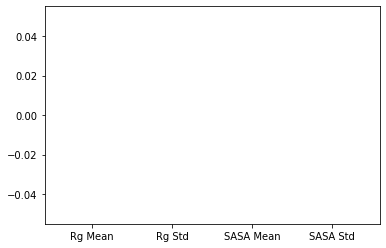

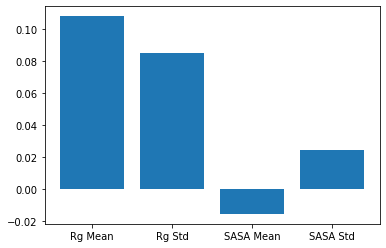

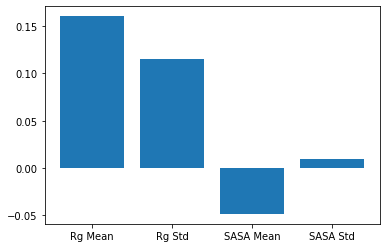

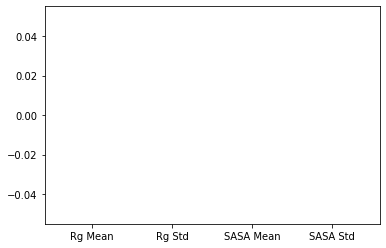

In [78]:
returned_scores, returned_model = run_pipeline(analysis_actors_dict, estim, parameters, maximize="f1", start=0, stop=2500)

In [56]:
print(returned_scores)

{'train': {'acc': 0.5914529914529915, 'f1': 0.41523125996810206, 'rec': 0.33333333333333337, 'auc': 0.6733333333333332}, 'test': {'acc': 0.4523809523809524, 'f1': 0.15714285714285717, 'rec': 0.13333333333333333, 'auc': 0.4222222222222222}}
